In [106]:
import h5py
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import re
from datetime import datetime, timedelta

In [120]:
sns.set_style()

In [107]:
# Load points_within
points_within = np.load('../data/points_within.npy', allow_pickle=True)

In [108]:
# Extract list of files
flood_path = '../data/Cambodia/flood'
files_list = os.listdir(flood_path)[1:]
ndvi_flood = [f for f in files_list if 'NDVI' in f]
print(ndvi_flood)

# Extract base files
base_path = '../data/Cambodia/base'
base_files = os.listdir(base_path)
ndvi_base = [f for f in base_files if 'NDVI' in f]
print(ndvi_base)

# Extract base_2 files
base_path_2 = '../data/Cambodia/base_2'
base_files_2 = os.listdir(base_path_2)
ndvi_base_2 = [f for f in base_files_2 if 'NDVI' in f]
print(ndvi_base_2)

['MOD13Q1.A2020145.mosaic.061.2024312230005.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020161.mosaic.061.2024312225943.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020177.mosaic.061.2024312225939.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020193.mosaic.061.2024312225941.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020209.mosaic.061.2024312225939.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020225.mosaic.061.2024312230007.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020241.mosaic.061.2024312225942.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020257.mosaic.061.2024312230000.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020273.mosaic.061.2024312225939.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020289.mosaic.061.2024312230004.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020305.mosaic.061.2024312230000.psmcrpgs_000502299593.250m_16_days_NDVI.h5', 'MOD13Q1.A2020321.mosaic.061.20

In [109]:
# Lat and Long range
lat_range = [12.3, 13.8]
long_range = [102.3, 103.8]

# Given this range and the data is in shape 721,707 grid, do a grid array
lat_grid = np.linspace(lat_range[0], lat_range[1], 721)
long_grid = np.linspace(long_range[0], long_range[1], 707)

# Create a meshgrid
long_grid, lat_grid = np.meshgrid(long_grid, lat_grid)

# Flatten the grid
lat_flatten = lat_grid.flatten()
long_flatten = long_grid.flatten()

In [110]:
def extract_date_from_name(file_name):
    date = re.findall(r'MOD13Q1\.A(.*?)\.mosaic', file_name)[0]
    year = date[:4]
    doy = date[4:]
    date = datetime(int(year), 1, 1) + timedelta(int(doy) - 1)
    date = date.strftime('%Y-%m-%d')
    return date

In [111]:
def read_EVI_NDVI(file):
    # Extract the filename
    filename = os.path.basename(file)
    # Open the file
    with h5py.File(file, 'r') as f:
        # Extract the group name
        group = list(f.keys())[0]
        # Extract the subgroups
        subgroups = list(f[group].keys())
        # Extract the first subgroup
        data = f[f"{group}/{subgroups[0]}"][:]
        # Add name with the file name
        name = extract_date_from_name(filename)

    return data, name


In [112]:
from scipy.spatial import KDTree

# Create a mask for lat and long inside the points_within
mask = np.zeros_like(lat_flatten)

# Combine lat and long into a single array of points
points = np.column_stack((lat_flatten, long_flatten))

# Create a KDTree for fast nearest neighbor search
tree = KDTree(points)

for point in points_within:
    lat = point.y
    long = point.x
    # Find the closest point in the KDTree
    dist, idx = tree.query([lat, long])
    mask[idx] = 1

In [205]:
# Create empty list to store flood data
flood_data = []
flood_gdf = []

# Loop through the flood files
for file in ndvi_flood:
    # Read the data
    data, name = read_EVI_NDVI(f"{flood_path}/{file}")
    # Flatten the data
    flood_data.append(data)
    data = data.flatten()

    # Select only when mask is 1
    data = data[mask == 1]
    lat = lat_flatten[mask == 1]
    long = long_flatten[mask == 1]

    # Create a dataframe
    df = pd.DataFrame({'lat': lat, 'long': long, 'NDVI': data})

    # Create a geodataframe
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
    gdf['date'] = name

    # Transform date to datetime
    gdf['date'] = pd.to_datetime(gdf['date'])

    # Append to the list
    flood_gdf.append(gdf)

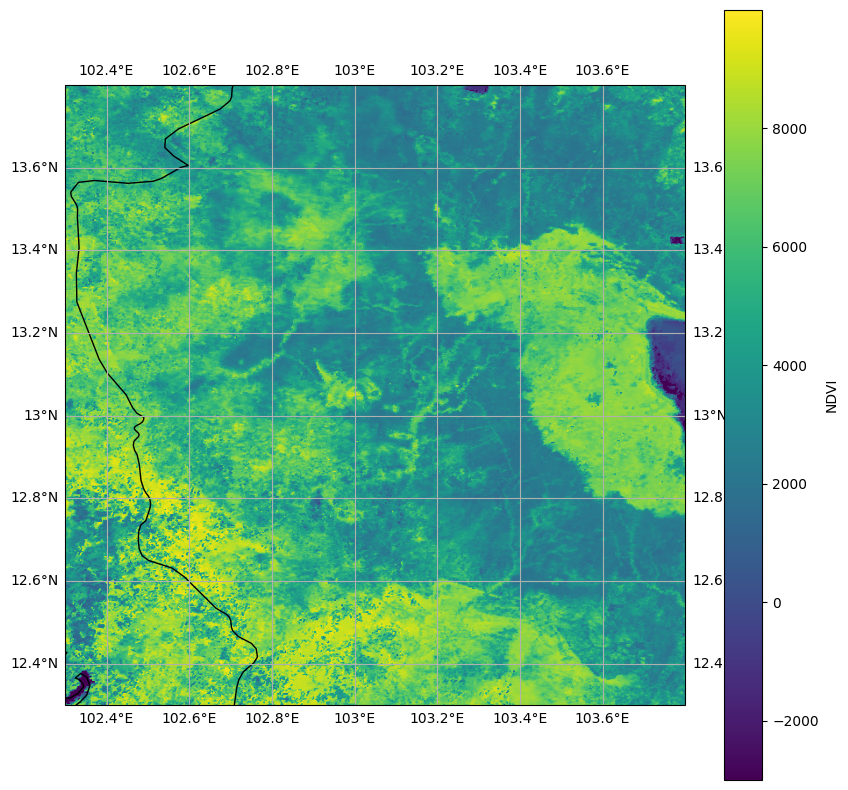

In [222]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a Cartopy GeoAxes
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Modify the x and y axis limits to fit the lat and long range
ax.imshow(flood_data[0], extent=[long_range[0], long_range[1], lat_range[0], lat_range[1]], transform=ccrs.PlateCarree())

# Add Cartopy features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

# Add gridlines
ax.gridlines(draw_labels=True)

# Add labels and colorbar
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(ax.imshow(flood_data[0], extent=[long_range[0], long_range[1], lat_range[0], lat_range[1]], transform=ccrs.PlateCarree()), label='NDVI')

plt.savefig('../figures/normal_NDVI.pdf', dpi=200, bbox_inches='tight')
plt.show()

In [114]:
base_data = []

# Loop through the base files
for file in ndvi_base:
    # Read the data
    data, name = read_EVI_NDVI(f"{base_path}/{file}")

    # Flatten the data
    data = data.flatten()

    # Select only when mask is 1
    data = data[mask == 1]
    lat = lat_flatten[mask == 1]
    long = long_flatten[mask == 1]

    # Create a dataframe
    df = pd.DataFrame({'lat': lat, 'long': long, 'NDVI': data})

    # Create a geodataframe
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
    gdf['date'] = name

    # Transform date to datetime
    gdf['date'] = pd.to_datetime(gdf['date'])

    # Append to the list
    base_data.append(gdf)

In [115]:
base_data_2 = []

# Loop through the base_2 files
for file in ndvi_base_2:
    # Read the data
    data, name = read_EVI_NDVI(f"{base_path_2}/{file}")

    # Flatten the data
    data = data.flatten()

    # Select only when mask is 1
    data = data[mask == 1]
    lat = lat_flatten[mask == 1]
    long = long_flatten[mask == 1]

    # Create a dataframe
    df = pd.DataFrame({'lat': lat, 'long': long, 'NDVI': data})

    # Create a geodataframe
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.long, df.lat))
    gdf['date'] = name

    # Transform date to datetime
    gdf['date'] = pd.to_datetime(gdf['date'])

    # Append to the list
    base_data_2.append(gdf)

In [128]:
# Concatenate the data
flood_gdf = pd.concat(flood_data)
base_gdf = pd.concat(base_data)
base_gdf_2 = pd.concat(base_data_2)

# Dissagregate the data to year and month
flood_gdf['year'] = flood_gdf['date'].dt.year
flood_gdf['month'] = flood_gdf['date'].dt.month

base_gdf['year'] = base_gdf['date'].dt.year
base_gdf['month'] = base_gdf['date'].dt.month

base_gdf_2['year'] = base_gdf_2['date'].dt.year
base_gdf_2['month'] = base_gdf_2['date'].dt.month

In [132]:
# Calculate the mean and median by date
flood_mean = flood_gdf.groupby('month')['NDVI'].mean()
flood_median = flood_gdf.groupby('month')['NDVI'].median()

base_mean = base_gdf.groupby('month')['NDVI'].mean()
base_median = base_gdf.groupby('month')['NDVI'].median()

base_mean_2 = base_gdf_2.groupby('month')['NDVI'].mean()
base_median_2 = base_gdf_2.groupby('month')['NDVI'].median()

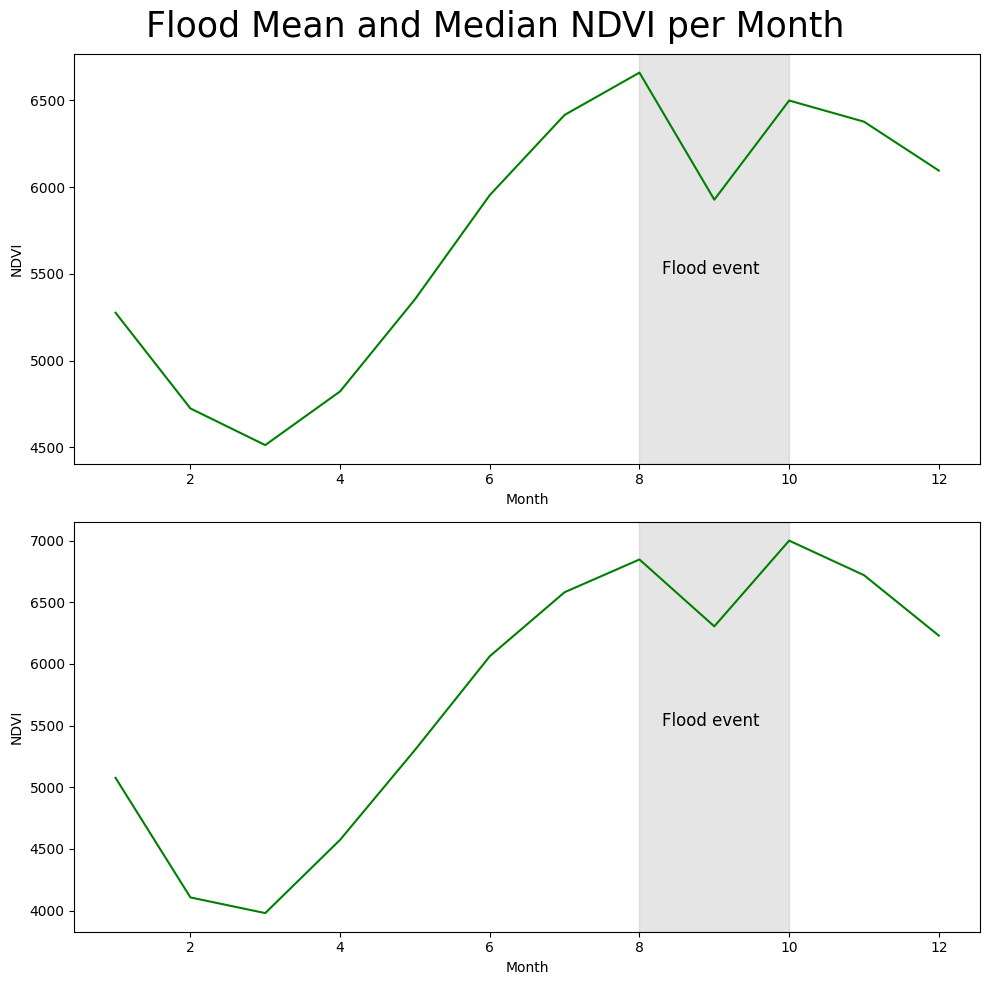

In [204]:
# Plot
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(flood_mean, label='Flood Mean', color='green')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('NDVI')

ax[1].plot(flood_median, label='Flood Median', color='green')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('NDVI')

# Set suptitle
fig.suptitle('Flood Mean and Median NDVI per Month', fontsize=25)

# Add a horizontal gray region between months 8 and 10
ax[0].axvspan(8, 10, color='gray', alpha=0.2)
ax[1].axvspan(8, 10, color='gray', alpha=0.2)

# Add text inside this region mentioning "Flood"
ax[0].text(8.3, 5500, 'Flood event', fontsize=12)
ax[1].text(8.3, 5500, 'Flood event', fontsize=12)

plt.tight_layout()

plt.savefig('../figures/flood_mean_median.pdf')
plt.show()

## Vulnerability analysis

Mean analysis

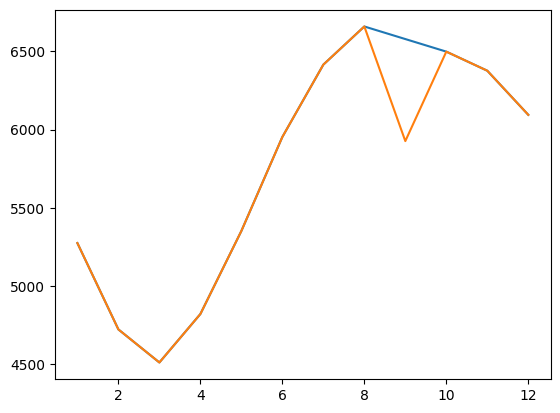

In [ ]:
# Assume that between month and 8 and 10 there is no flood, so interpolate month 9
data_mean = flood_mean.copy()
data_mean[9] = (data_mean[8] + data_mean[10]) / 2

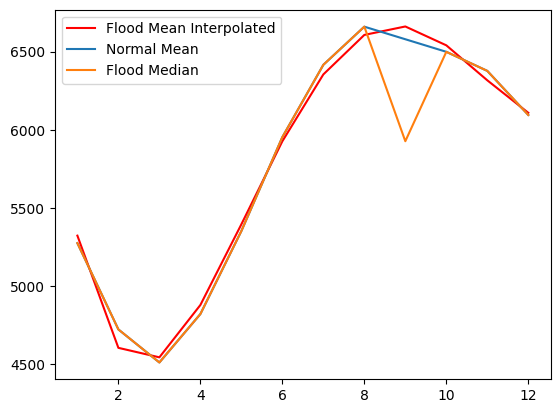

In [173]:
# Fit a polynomial of degree 3 in data_mean
x = np.arange(1, 13)
y = data_mean.values
z = np.polyfit(x, y, 4)
p = np.poly1d(z)

# Plot the polynomial
plt.plot(x, p(x), label='Flood Mean Interpolated', color='red')
plt.plot(data_mean, label='Normal Mean')
plt.plot(flood_mean, label='Flood Median')
plt.legend()

In [169]:
flood_mean

month
1     5275.524670
2     4723.867189
3     4512.571855
4     4822.097474
5     5352.587710
6     5953.295504
7     6415.411197
8     6659.264334
9     5926.943560
10    6498.507354
11    6376.542394
12    6094.686722
Name: NDVI, dtype: float64

In [224]:
loss = -(flood_mean.values - p(x))/ p(x) * 100
loss = loss[7:11]
flood_depth = [0.5, 1.4, 0.2]

print(loss, flood_depth)

[-0.79860385 11.01356861  0.63362633 -0.9538673 ] [0.5, 1.4, 0.2]


ModuleNotFoundError: No module named 'pymc3'